$\Large\textbf{Portfolio allocation with (Minimum variance) and (Mean-variance) Portfolios}$

$\small\textbf{Written by Ahmad Bittar}$ - Last modified in 15/10/2025

${\color{red} \text{Import the necessary packages}}$

In [2]:
import cvxpy as cp

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import minimize
import yfinance as yf

${\color{red} \text{Define the symbols}}$

In [4]:
symbols = ['Stock1','Stock2','Stock3','Stock4','Stock5']

${\color{red} \text{Define the start date \& end date}}$

In [5]:
# The end date is today
end_date = datetime.today() 

# The start date is five years from today
start_date = end_date - timedelta(days = 5*365) 

${\color{red} \text{Define a list of 100 dates between start and end dates}}$

In [6]:
list_of_dates = [start_date + timedelta(days=x) for x in range(5*365)]

${\color{red} \text{Create the dataframe of stock prices}}$

In [7]:
# Stock price at initial date
Stock_price_InitialDate = 100

# Define the maturity
T = 1

# Initialize the stock drifts
mu = 0.02

# Initialize the stock volatility
sigma = 0.02

# Total number of steps
num_steps = 5*365 - 1

# Define step size
dt = T / num_steps

# Total number of simulations
num_sim = len(symbols)

# Initialize the matrix of stock prices
S = np.zeros((num_steps+1, num_sim))

# Calculate the stock prices
S[0, :] = Stock_price_InitialDate
for j in range(num_steps):
    S[j+1, :] = S[j, :] + mu * S[j, :] * dt + sigma * S[j, :] * np.sqrt(dt) * np.random.normal(0, 1, size = (1, num_sim))

${\color{red} \text{Plot stock prices}}$

Text(0.5, 1.0, 'Stock prices')

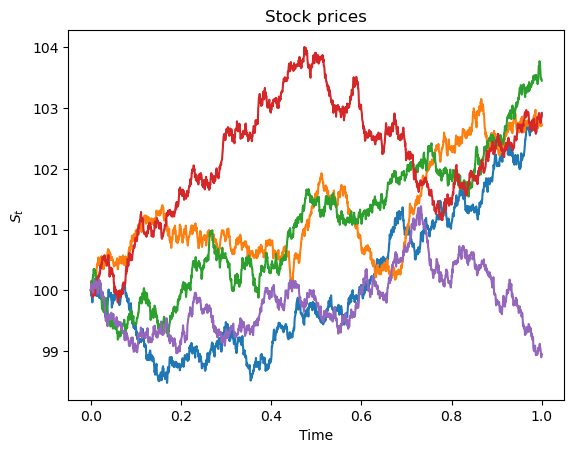

In [8]:
time = np.linspace(0, T, num_steps+1)
plt.figure()
plt.plot(time, S)
plt.xlabel("Time")
plt.ylabel("$S_t$")
plt.title("Stock prices")

In [9]:
data = pd.DataFrame({symbols[0]: S[:, 0], symbols[1]: S[:, 1], symbols[2]: S[:, 2], symbols[3]: S[:, 3], symbols[4]: S[:, 4]})
data.index = list_of_dates
data

,Stock1,Stock2,Stock3,Stock4,Stock5
2020-10-16 14:10:39.409425,100.000000,100.000000,100.000000,100.000000,100.000000
2020-10-17 14:10:39.409425,99.945521,100.050351,100.031355,100.002813,100.018415
2020-10-18 14:10:39.409425,99.908556,100.136448,100.081138,99.979322,100.103653
2020-10-19 14:10:39.409425,99.923676,100.156696,100.152166,100.018665,100.009779
2020-10-20 14:10:39.409425,99.888150,100.105997,100.105069,100.028569,100.012689
...,...,...,...,...,...
2025-10-10 14:10:39.409425,102.853934,102.709785,103.487345,102.763355,98.990636
2025-10-11 14:10:39.409425,102.835715,102.763758,103.475814,102.781804,98.941642
2025-10-12 14:10:39.409425,102.855913,102.763888,103.487263,102.818601,98.895257
2025-10-13 14:10:39.409425,102.858340,102.710230,103.475133,102.864516,98.943960


${\color{red} \text{Calculate log returns (and drop all NaN values)}} $

In [10]:
log_returns = np.log(data / data.shift(1))
log_returns = log_returns.dropna()

${\color{red} \text{Estimate the true (unknown) covariance matrix}} $

In [11]:
covariance_matrix = log_returns.cov()*252

${\color{red} \text{Estimate the true (unknown) mean}} $

In [12]:
estimated_mu = log_returns.mean()
estimated_mu = np.reshape(estimated_mu, (len(estimated_mu),1))
print("Empirical mean :\n ", estimated_mu, ".")

Empirical mean :
  [[ 1.57848053e-05]
 [ 1.46864133e-05]
 [ 1.86061515e-05]
 [ 1.57177588e-05]
 [-5.80539819e-06]] .


${\color{red} \text{Mean-variance Portfolio}}$

In [13]:
def solve_markowitz_wpos_w1(mu, Sigma, lbda, w_previous, theta = 0):
    n = len(Sigma)
    w = cp.Variable(n)

    constraints = [w >=0,cp.sum(w)==1]

    obj = cp.Maximize(mu.T @ w - lbda/2 * cp.quad_form(w, Sigma) - theta*cp.norm(w-w_previous,2))

    prob = cp.Problem(obj, constraints)
    prob.solve()

    return w.value

${\color{red} \text{Minimum Variance Portfolio}}$

In [14]:
def min_var_portfolio_less_short(Sigma, min_short,w_previous, theta = 0):
    n=len(Sigma)
    w = cp.Variable(n)

    constraints = [w>=min_short,cp.sum(w)==1]
    risk = cp.quad_form(w, Sigma)
    obj = cp.Minimize(risk + theta*cp.norm(w-w_previous,2))

    prob = cp.Problem(obj, constraints)
    prob.solve()
    return w.value

${\color{red} \text{Estimate the weights with minimum-variance portfolio}} $

In [28]:
w_previous = np.ones(len(symbols))
estimated_weights_minimum_Variance = min_var_portfolio_less_short(covariance_matrix, 0, w_previous) # with minimum-variance portfolio
estimated_weights_Markowitz = solve_markowitz_wpos_w1(estimated_mu, covariance_matrix, 0.01, w_previous) # with mean-variance portfolio
print("Estimated weights with minimum variance portfolio are ", estimated_weights_minimum_Variance, ".")
print("Estimated weights with mean variance portfolio are ", estimated_weights_Markowitz, ".")

Estimated weights with minimum variance portfolio are  [0.19753808 0.21229438 0.18584465 0.20725764 0.19706526] .
Estimated weights with mean variance portfolio are  [8.33643502e-08 7.54062058e-08 9.99999750e-01 8.48332255e-08
 6.78153952e-09] .


${\color{red} \text{Calculate the expected return of the portfolio}}$

In [29]:
expected_returns_minimum_Variance = np.dot(estimated_mu.T, estimated_weights_minimum_Variance) * 252
expected_returns_Markowitz = np.dot(estimated_mu.T, estimated_weights_Markowitz) * 252
print("Expected portfolio return with minimum variance : ", expected_returns_minimum_Variance, ".")
print("Expected portfolio return with mean-variance : ", expected_returns_Markowitz, ".")

Expected portfolio return with minimum variance :  [0.00297546] .
Expected portfolio return with mean-variance :  [0.00468875] .


${\color{red} \text{Calculate the risk of the portfolio}}$

In [30]:
Risk_minimum_Variance = np.sqrt(np.dot(np.dot(estimated_weights_minimum_Variance.T, covariance_matrix), estimated_weights_minimum_Variance))
Risk_Markowitz = np.sqrt(np.dot(np.dot(estimated_weights_Markowitz.T, covariance_matrix), estimated_weights_Markowitz))
print("Portfolio risk with minimum variance : ", Risk_minimum_Variance, ".")
print("Portfolio risk with mean-variance : ", Risk_Markowitz, ".")

Portfolio risk with minimum variance :  0.0034124901945655583 .
Portfolio risk with mean-variance :  0.00754280182765547 .


${\color{red} \text{Calculate the sharp ratio}}$

In [31]:
sharpe_ratio_minimum_Variance = expected_returns_minimum_Variance / Risk_minimum_Variance
sharpe_ratio_Markowitz = expected_returns_Markowitz / Risk_Markowitz
print("Sharp ratio with minimum variance portfolio : ", sharpe_ratio_minimum_Variance, ".")
print("Sharp ratio with mean-variance portfolio : ", sharpe_ratio_Markowitz, ".")

Sharp ratio with minimum variance portfolio :  [0.87193211] .
Sharp ratio with mean-variance portfolio :  [0.62161913] .


${\color{red} \text{Calculate the portfolio cumulative returns (for each date)}}$

In [32]:
Portfolio_log_returns_minimum_Variance = np.dot(log_returns, estimated_weights_minimum_Variance)
Portfolio_log_returns_append_minimum_Variance = np.append(100,Portfolio_log_returns_minimum_Variance)
Portfolio_cumulative_returns_minimum_Variance = 100 * (Portfolio_log_returns_minimum_Variance + 1).cumprod()

Portfolio_log_returns_Markowitz = np.dot(log_returns, estimated_weights_Markowitz)
Portfolio_log_returns_append_Markowitz = np.append(100,Portfolio_log_returns_Markowitz)
Portfolio_cumulative_returns_Markowitz = 100 * (Portfolio_log_returns_Markowitz + 1).cumprod()

${\color{red} \text{Plot the portfolio cumulative returns (for each date)}}$

Text(0.5, 1.0, 'Portfolio wealth')

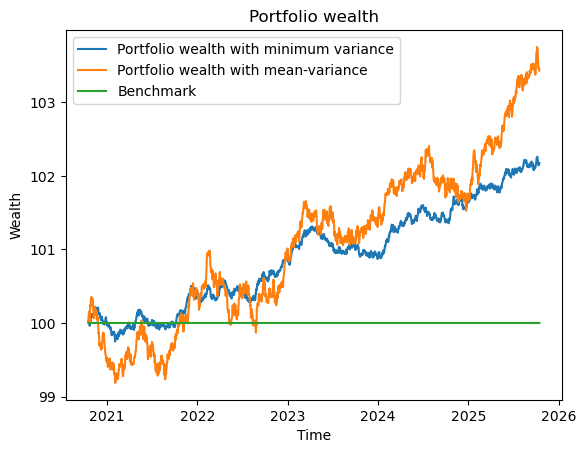

In [33]:
ones_vector = np.ones(len(Portfolio_log_returns_minimum_Variance))
plt.figure()
plt.plot(data.index[1:], Portfolio_cumulative_returns_minimum_Variance)
plt.plot(data.index[1:], Portfolio_cumulative_returns_Markowitz)
plt.plot(data.index[1:], 100*ones_vector)
plt.xlabel("Time")
plt.ylabel("Wealth")
plt.legend(['Portfolio wealth with minimum variance', 'Portfolio wealth with mean-variance', 'Benchmark'])
plt.title("Portfolio wealth")